# Example of computation of Blob size on TCV

In this notebook I summarize the main steps used in the computation of the blob size on TCV. In doing so I've created an appropriate python class **tcvFilaments** which is saved in */home/vianello/NoTivoli/work/topic21/Codes/python/tcv* and available also on github at *https://github.com/nicolavianello/topic21* 

First step is to be sure we have all the appropriate path defined in within python

In [46]:
import sys
sys.path.append('/home/vianello/NoTivoli/work/topic21/Codes/python/general')
sys.path.append('/home/vianello/NoTivoli/work/topic21/Codes/python/tcv')
%matplotlib inline
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
from lmfit.models import GaussianModel
from scipy import constants

In [2]:
import tcvFilaments

/home/vianello/NoTivoli/anaconda2/lib/python2.7/site-packages/eqtools/AUGData.py:38: ModuleWarning: dd module could not be loaded -- classes that use dd for data access will not work.
  ModuleWarning)


You are not at IPP dd and map_equ not find


Now we choose a generic pulse among all the available in the database as **54873**

In [4]:
Data = tcvFilaments.Turbo(54873)

One of the method defined in the class is called **blob**. This is the main method which makes all the computation. I will show step by step what the method is doing. It is called with a series of keyword which are:
+ *rrsep = [0.01,0.015]* This define the region in terms of distance to the separatrix at the midplane where the signal will be analyzed. We can also give this numbers in terms of normalized poloidal flux, in this case specifying *rho*
+ *rmsNorm* If given, since we are using also the time during the plunge of the probe, and thus not a stationary signal the reference signal (Ion saturation current) is normalized in the form $$ \frac{f - \langle f\rangle}{\sigma_f}$$ where the average and rms are running average and rms over a time window which can be specified using the keyword **dtS**. The default is **dtS = 0.0002**
+ *threshold* This is the threshold usedf for the determination of the blob. If **rmsNorm** keyword is set to **True** it can be given in terms of rms value (default is 3)
+ *iwin* this is the time window used for the **Conditional average sample**
+ *detrend* Again this is a boolean and if set to True it subtract from the signal a linear trend in each of the iwin time window before averaging
+ *plunge* This is the plunge number 1 or 2

In [25]:
Blob = Data.blob(plunge=1,rrsep=[0.01,0.015],rmsNorm=True,detrend=True,iwin=75)

Already loaded
Using new threshold method
Number of structure mediated   31
Using Lambda from Tree
Using Lambda from Tree


We have some **warnings** which are minor issues and we can not consider them.

First of all verify that we are considering the time window which is at the correct distance from the separatrix. The output of **blob** method in the class save the minimum and maximum time used for the analysis as attributes

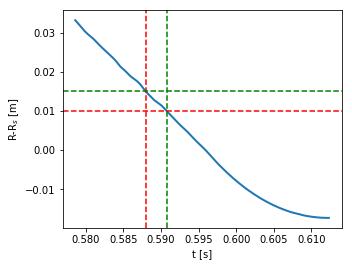

In [26]:
fig,ax = pylab.subplots(nrows=1,ncols=1,figsize=(5,4))
ax.plot(Data.Rtime,Data.RRsep,lw=2)
ax.set_xlabel(r't [s]')
ax.set_ylabel(r'R-R$_s$ [m]')
ax.axvline(Blob.tmin,ls='--',color='r')
ax.axvline(Blob.tmax,ls='--',color='g')
ax.axhline(0.01,ls='--',color='r')
ax.axhline(0.015,ls='--',color='g')

Verify also in terms of signals and how the normalized signals looks like. Since the **tcvFilaments.Turbo** class call a method named **timeseries** to access the real normalized signal used for the analysis we need to access the attributes *rmsnorm* in the **Data.Structure** which is the **timeseries** object called within the **Turbo** class

(0, 1)

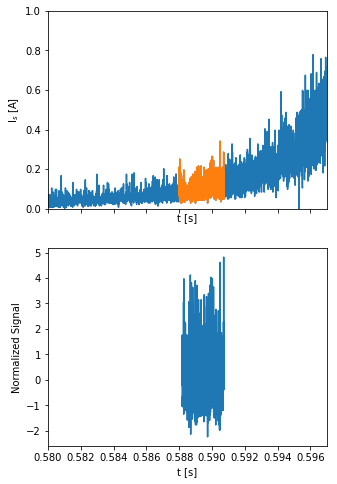

In [27]:
fig,ax = pylab.subplots(figsize=(5,8),nrows=2,ncols=1,sharex=True)
ax[0].plot(Data.iS.time,Data.iS.values)
a = Data.iS.where((Data.iS.time >= Blob.tmin) & (Data.iS.time <= Blob.tmax),drop=True)
ax[0].plot(a.time,a.values)
ax[0].set_ylabel(r'I$_s$ [A]')
ax[0].set_xlabel(r't [s]')
ax[1].plot(a.time,Data.Structure.rmsnorm)
ax[1].set_ylabel(r'Normalized Signal')
ax[1].set_xlabel(r't [s]')
ax[1].set_xlim([0.58,0.597])
ax[0].set_ylim([0,1])

We can now observe where the intermittent structures are detected within the normalized signal chosen

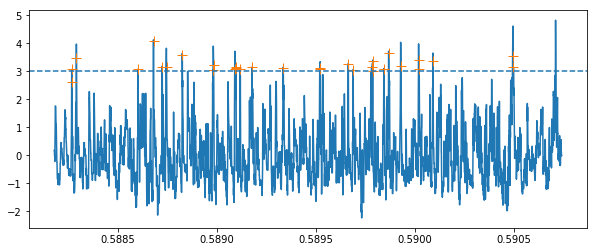

In [29]:
fig,ax = pylab.subplots(figsize=(10,4),nrows=1,ncols=1)
ax.plot(a.time,Data.Structure.rmsnorm)
ax.plot(a.time[Data.Structure._locationindex],Data.Structure.rmsnorm[Data.Structure._locationindex],'+',ms=10)
ax.axhline(3,ls='--')

The last point is not detected because within an iwin distance from the end of the timewindow. Now we can give a look on the typical **Conditional average structure** computed on ion saturation current, and on the different floating potential plus on the poloidal electric field

Text(0,0.5,u'[A]')

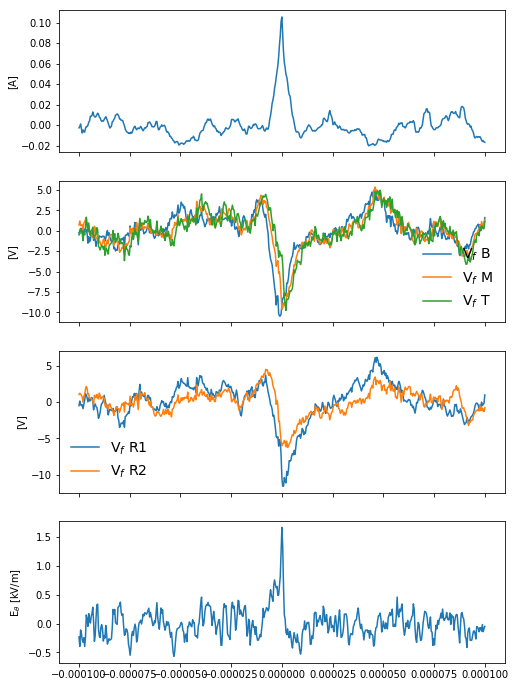

In [32]:
fig,ax = pylab.subplots(figsize=(8,12),nrows=4,ncols=1,sharex=True)
ax[0].plot(Blob.t,Blob.sel(sig='Is'))
ax[1].plot(Blob.t,Blob.sel(sig='VFB_1'),label=r'V$_f$ B')
ax[1].plot(Blob.t,Blob.sel(sig='VFM_1'),label=r'V$_f$ M')
ax[1].plot(Blob.t,Blob.sel(sig='VFT_1'),label=r'V$_f$ T')
ax[2].plot(Blob.t,Blob.sel(sig='VFR1_1'),label=r'V$_f$ R1')
ax[2].plot(Blob.t,Blob.sel(sig='VFR2_1'),label=r'V$_f$ R2')
ax[3].plot(Blob.t,Blob.sel(sig='Epol')/1e3)
ax[1].legend(loc='best',numpoints=1,frameon=False,fontsize=14)
ax[2].legend(loc='best',numpoints=1,frameon=False,fontsize=14)
ax[3].set_ylabel(r'E$_\theta$ [kV/m]')
ax[2].set_ylabel(r'[V]')
ax[1].set_ylabel(r'[V]')
ax[0].set_ylabel(r'[A]')

Now I clarify how I compute the FWHM. This is done within the class but I explicitly compute it for clarity

In [33]:
from scipy.interpolate import UnivariateSpline

In [34]:
x,y = Blob.t.values,Blob.sel(sig='Is').values

*x* and *y* are respectively the time and the Is conditionally sampled. I normalize y to it's minmimum value and then I interpolate this signal subtracted by half the value of its maximum. Then I estimate a spline interpolation taking the corresponding roots, checking for possible multiple roots

In [35]:
_dummy = (y - y.min())
spline = UnivariateSpline(x, _dummy - _dummy.max() / 2, s=0)
if spline.roots().size > 2:
    a = np.sort(spline.roots())
    r1 = a[a < 0][-1]
    r2 = a[a > 0][0]
else:
    r1, r2 = spline.roots()

Check the results

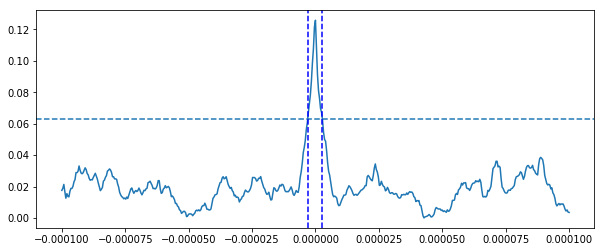

In [37]:
fig,ax = pylab.subplots(nrows=1,ncols=1,figsize=(10,4))
ax.plot(x,_dummy)
ax.axhline(_dummy.max()/2,ls='--')
ax.axvline(r1,ls='--',color='b')
ax.axvline(r2,ls='--',color='b')

The radial velocity is computed using the $$\mathbf{E}\times\mathbf{B}$$ velocity with the poloidal electric field from poloidally separated pins (**Top** and **Medium** pins). The value of the poloidal field is taken as the difference between minimum and maximum of the conditionally average samples within a interval of $$2\times\mathrm{FWHM}$$

Radial velocity is 1.47 kms


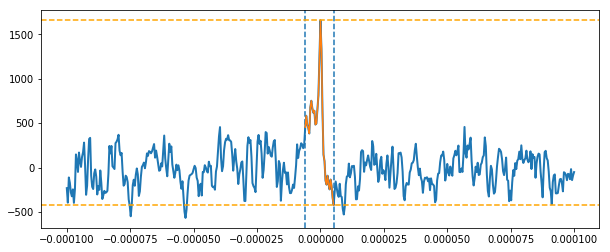

In [61]:
fig,ax = pylab.subplots(nrows=1,ncols=1,figsize=(10,4))
ax.plot(Blob.t,Blob.sel(sig='Epol'),lw=2)
ax.axvline(2*r1,ls='--')
ax.axvline(2*r2,ls='--')
_tmp = Blob.sel(sig='Epol').where((Blob.t >= 2*r1) & (Blob.t <= 2*r2),drop=True)
ax.plot(_tmp.t,_tmp.values)
ax.axhline(_tmp.max(),ls='--',color='orange')
ax.axhline(_tmp.min(),ls='--',color='orange')
Btot = 1.41 # this value is actually computed within the class for simplicity I give the value directly
vr = (_tmp.max()-_tmp.min())/Btot
print('Radial velocity is %3.2f' % (vr/1e3) + r' kms')

This is actually a weak poin for me since there are cases where the peak on the poloidal electric field is not so clear and instead there is a strong asymmetric shape. I will show later another example to clarify.
The computation of the poloidal motion is done using a 3 point cross-correlation.
Again all the computation is within the class **tcvFilaments.Turbo** but I clarify here step by step. First compute the cross-correlation between floating potential pins **M** and **T** which have been previously highpass filtered  having care for the existence of possible NaNs.
After a discussion with Cedric the cross-correlation is not computed on the Conditional Average Sampled floating potentials but rather on the floating potentials after an highpass butterworth filter of the 5 order at 10 kHz. The filter is computed using the entire plunge and then we select the time window again within the **[tmin,tmax]** interval.
For a better computation we make a GaussianFit so that the center of the fit is the appropriate time lag we need to compute. The velocity is then computed as the distance divided by the time lag and we can also estimate the corresponding error. 

Velocity from cross-correlation VFM-VFT is -3.36476393868 km/s


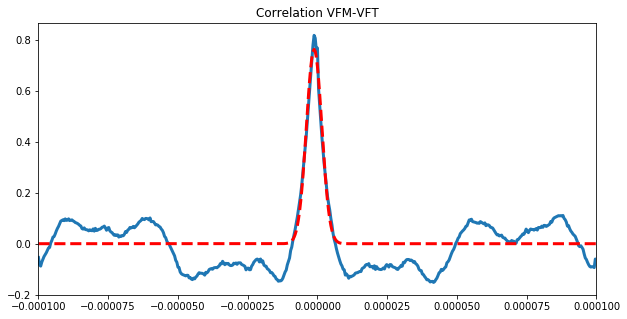

In [63]:
data = Data.vFF[:, ((Data.vF.time >= Blob.tmin) & (Data.vF.time <= Blob.tmax))]
a = data.sel(Probe='VFM_' + str(int(Data.plunge)))
b = data.sel(Probe='VFT_' + str(int(Data.plunge)))
_dummy = np.vstack((a, b)).transpose()
_dummy = _dummy[~np.isnan(_dummy).any(1)]
a = _dummy[:, 0]
b = _dummy[:, 1]
xcorA = np.correlate(a, b, mode='same')
# normalize appropriately
xcorA /= np.sqrt(np.dot(a, a) * np.dot(b, b))
lagA = np.arange(xcorA.size, dtype='float') - xcorA.size / 2
lagA *= Data.dt
fig,ax = pylab.subplots(nrows=1,ncols=1,figsize=(10,5))
ax.plot(lagA,xcorA,'-',lw=3)
ax.set_xlim([-0.0001,0.0001])
ax.set_title('Correlation VFM-VFT')
mod = GaussianModel()
pars = mod.guess(xcorA, x=lagA)
# limit the sigma of the gaussian to a
# suitable initial value of 1e-5
pars['sigma'].set(value=1e-5, vary=True)
out = mod.fit(xcorA, pars, x=lagA)
# centroid with the error
dtA = out.params['center'].value
dtAS = out.params['center'].stderr
# compute velocity with error
vpA = (0.2433 - 0.0855) * constants.inch / dtA
ax.plot(lagA,out.best_fit,'r--',lw=3)
dtA = out.params['center'].value
dtAS = out.params['center'].stderr
# compute velocity with error
vpA = (0.2433 - 0.0855) * constants.inch / dtA
vpAS = vpA * (dtAS/dtA)
print('Velocity from cross-correlation VFM-VFT is ' + str(vpA/1e3) + r' km/s')

We repeat for another couple of floating potentials **B** and **T**

Velocity from cross-correlation VFB-VFT is -3.20574558136 km/s


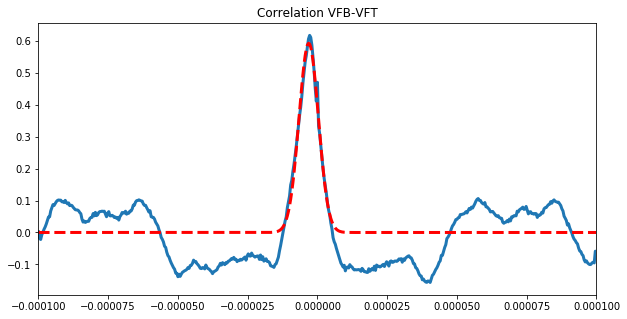

In [64]:
data = Data.vFF[:, ((Data.vF.time >= Blob.tmin) & (Data.vF.time <= Blob.tmax))]
a = data.sel(Probe='VFB_' + str(int(Data.plunge)))
b = data.sel(Probe='VFT_' + str(int(Data.plunge)))
_dummy = np.vstack((a, b)).transpose()
_dummy = _dummy[~np.isnan(_dummy).any(1)]
a = _dummy[:, 0]
b = _dummy[:, 1]
xcorB = np.correlate(a, b, mode='same')
# normalize appropriately
xcorB /= np.sqrt(np.dot(a, a) * np.dot(b, b))
lagB = np.arange(xcorB.size, dtype='float') - xcorB.size / 2
lagB *= Data.dt
fig,ax = pylab.subplots(nrows=1,ncols=1,figsize=(10,5))
ax.plot(lagB,xcorB,'-',lw=3)
ax.set_xlim([-0.0001,0.0001])
ax.set_title('Correlation VFB-VFT')
mod = GaussianModel()
pars = mod.guess(xcorB, x=lagB)
# limit the sigma of the gaussian to a
# suitable initial value of 1e-5
pars['sigma'].set(value=1e-5, vary=True)
out = mod.fit(xcorB, pars, x=lagB)
# centroid with the error
dtB = out.params['center'].value
dtBS = out.params['center'].stderr
# compute velocity with error
vpB = (0.2433 + 0.1512) * constants.inch / dtB
ax.plot(lagB,out.best_fit,'r--',lw=3)
dtB = out.params['center'].value
dtBS = out.params['center'].stderr
print('Velocity from cross-correlation VFB-VFT is ' + str(vpB/1e3) + r' km/s')

We use the average between these evaluation as the best estimate for $$v_{p}$$
The same procedure is then used to compute the $$v_r$$ as the average between the couples **M**-**R1** and **M**-**R2**. 

Velocity from cross-correlation VFM-VFR1 is -3.67809397112 km/s
Velocity from cross-correlation VFM-VFR2 is -1.16787187462 km/s


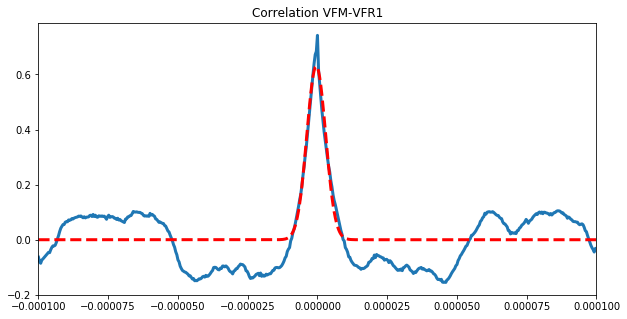

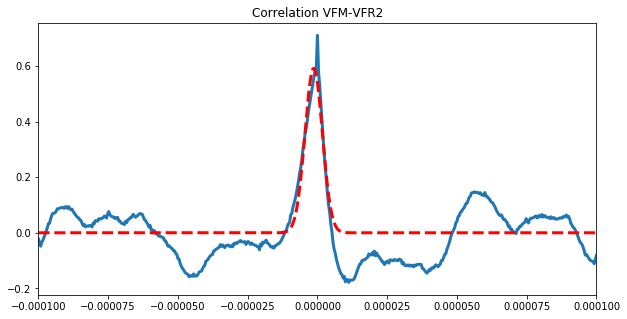

In [69]:
# now do the same
# for the radial ones
# couple M-R1
a = data.sel(Probe='VFM_' + str(int(Data.plunge)))
b = data.sel(Probe='VFR1_' + str(int(Data.plunge)))
_dummy = np.vstack((a, b)).transpose()
_dummy = _dummy[~np.isnan(_dummy).any(1)]
a = _dummy[:, 0]
b = _dummy[:, 1]
# compute the cross correlation
xcorC = np.correlate(a, b, mode='same')
# normalize appropriately
xcorC /= np.sqrt(np.dot(a, a) * np.dot(b, b))
lagC = np.arange(xcorC.size, dtype='float') - xcorC.size / 2
lagC *= Data.dt
mod = GaussianModel()
pars = mod.guess(xcorC, x=lagC)
pars['sigma'].set(value=1e-5, vary=True)
out = mod.fit(xcorC, pars, x=lagC)
# centroid with the error
dtC = out.params['center'].value
dtCS = out.params['center'].stderr
# compute velocity with error
vrC = (1.57e-3) / dtC
vrCS = vrC * (dtCS/dtC)
fig,ax = pylab.subplots(nrows=1,ncols=1,figsize=(10,5))
ax.plot(lagC,xcorC,'-',lw=3)
ax.set_xlim([-0.0001,0.0001])
ax.set_title('Correlation VFM-VFR1')
ax.plot(lagC,out.best_fit,'r--',lw=3)
print('Velocity from cross-correlation VFM-VFR1 is ' + str(vrC/1e3) + r' km/s')
#
# couple M-R2
a = data.sel(Probe='VFM_' + str(int(Data.plunge)))
b = data.sel(Probe='VFR2_' + str(int(Data.plunge)))
_dummy = np.vstack((a, b)).transpose()
_dummy = _dummy[~np.isnan(_dummy).any(1)]
a = _dummy[:, 0]
b = _dummy[:, 1]
# compute the cross correlation
xcorD = np.correlate(a, b, mode='same')
# normalize appropriately
xcorD /= np.sqrt(np.dot(a, a) * np.dot(b, b))
lagD = np.arange(xcorD.size, dtype='float') - xcorD.size / 2
lagD *= Data.dt
mod = GaussianModel()
pars = mod.guess(xcorD, x=lagD)
pars['sigma'].set(value=1e-5, vary=True)
out = mod.fit(xcorD, pars, x=lagD)
# centroid with the error
dtD = out.params['center'].value
dtDS = out.params['center'].stderr
# compute velocity with error
vrD = (1.57e-3) / dtD
vrDS = vrC * (dtDS/dtD)
fig,ax = pylab.subplots(nrows=1,ncols=1,figsize=(10,5))
ax.plot(lagD,xcorD,'-',lw=3)
ax.set_xlim([-0.0001,0.0001])
ax.set_title('Correlation VFM-VFR2')
ax.plot(lagC,out.best_fit,'r--',lw=3)
print('Velocity from cross-correlation VFM-VFR2 is ' + str(vrD/1e3) + r' km/s')

Once we have the computation of $$v_{p}$$ and $$v_r$$ we then compute the angle $$\theta = \arctan(v_r/v_p)$$ and the corresponding component $$v_z = v_p*\sin(\theta)^2$$. Finally we use the evaluation of radial velocity from $$\mathbf{E}\times\mathbf{B}$$ as above and the newly computed $$v_z$$ to estimate the blob-size as $$Size = \tau\sqrt{(v_r^{E\times B})^2 + v_z^2}$$

In [70]:
vp = np.mean([vpA,vpB])
vrr = np.nanmean([vrC,vrD])
Theta = np.arctan(vrr/vp)
vz = vp*np.power(np.sin(Theta),2)
Size = (r2-r1)*np.sqrt(np.power(vr,2) + np.power(vz,2))
print('Blob size is %4.2f' % (Size*1e3) + ' mm')

Blob size is 10.87 mm


There are few cases which actually have behavior we should discuss. For example if we consider the shot 57082 and compute the blobs as measured from 1 to 2 cm from the LCFS we get the following shape for $$E_{z}$$. This is strongly asymmetric and it's hard to get even if we consider the 2 FWHM intervals. **How do you treat these cases**?

Using new threshold method
Number of structure mediated   42
Using Lambda from Tree
Using Lambda from Tree


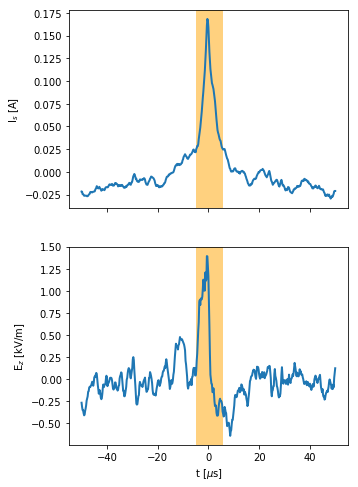

In [73]:
Data2 = tcvFilaments.Turbo(57082)
Blob2 = Data2.blob(plunge=1,rrsep=[0.01,0.02],rmsNorm=True,detrend=True,iwin=50)
fig,ax = pylab.subplots(nrows=2,ncols=1,sharex=True,figsize=(5,8))
ax[0].plot(Blob2.t*1e6,Blob2.sel(sig='Is'),lw=2)
ax[1].plot(Blob2.t*1e6,Blob2.sel(sig='Epol')/1e3,lw=2)
ax[0].set_ylabel(r'I$_s$ [A]')
ax[1].set_ylabel(r'E$_z$ [kV/m]')
ax[1].set_xlabel(r't [$\mu$s]')
# we also compute the FWHM as done before. Again this is within the class but I repeat step by step
x = Blob2.t.values
y = Blob2.sel(sig='Is').values
_dummy = (y - y.min())
spline = UnivariateSpline(x, _dummy - _dummy.max() / 2, s=0)
if spline.roots().size > 2:
    a = np.sort(spline.roots())
    r1 = a[a < 0][-1]
    r2 = a[a > 0][0]
else:
    r1, r2 = spline.roots()
ax[0].axvspan(2*r1*1e6,2*r2*1e6,facecolor='orange',alpha=0.5)
ax[1].axvspan(2*r1*1e6,2*r2*1e6,facecolor='orange',alpha=0.5)